In [2]:
# Uncomment to install packages
# !pip install -U scikit-learn scipy category_encoders
# !pip install -U matplotlib seaborn
# !pip install -U pandas pandasql

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import pandasql as ps
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from category_encoders import WOEEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    PrecisionRecallDisplay, 
    ConfusionMatrixDisplay,
    confusion_matrix
)

# __Introduction__

In this project, we aim at predicting probability of default with data from HomeLoan. The full dataset is consisted of three parts,
* `application_train.csv`, information about applicant at the application time
* `bureau.csv` and `bureau_balance.csv`, past data from credit bureau 
* past payments, such as spending history, credit card balance history

The application data is the main table and we need to combine these three data sources to construct the final model for default prediction. Our strategy is to construct three sub-models for each one of the three data sources and use a linear model to combine the three calculated credit scores to produce a "master score." Therefore, this notebook is partitioned into four parts where the first three parts are the modeling procedures for three data sources, __each one of the team members will handle one part individually__, and the final part is for the model-combo. 

In all of the following sections, we assume that the __datasets are placed under the folder named `raw-data/`. The folder `raw-data/` should be placed under the same folder as this notebook `report.ipynb`.__ Dataset can be found on _Kaggle_ with [this link.](https://www.kaggle.com/c/home-credit-default-risk/data) This notebook will generate some intermediate results that will be put under `combo-data/`.

In [2]:
if not os.path.exists('combo-data'):
    os.makedirs('combo-data')

if not os.path.exists('raw-data'):
    raise OSError('Cannot find data folder <raw-data/>')

# __Part I, Modeling with `application_{train|test}.csv`__

## __Dataset Overview__

In this notebook we explore `application_{train|test}.csv`, the main tables. According to the data description from _Kaggle_, the dataset contains predictors about the loan and loan applicants at application time. From the basic statistics, there are 307511 rows in total (training set). Each row represents a unique application. We also see that there are 122 columns, most of which are information regarding the loan application ($X$ predictors) and `TARGET` column denotes the weather the applicant default the loan ($y$ labels). Among the 122 columns, 106 of them are numeric and 16 are categorical (`object`). We can further divide the numerical columns into `float64` and `int64` columns. A more detailed examination deserves its own section.

In [4]:
df_app = pd.read_csv('raw-data/application_train.csv', index_col='SK_ID_CURR')
df_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


In [5]:
df_app.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   
100006           0         Cash loans           F            N   
100007           0         Cash loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                ...                    
100002          24700.5         351000.0  ...                0   
100003          35698.5        1129500.0  ...                0   
100004           6750.0         135000.0  ...                0   
100006          29686.5         297000.0  ...                0   
100007          21865.5         513000.0  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
100002                    0                0                0   
100003                    0                0                0   
100004                    0                0                0   
100006                    0                0                0   
100007                    0                0                0   

           AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                         
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   
100006                            NaN                        NaN   
100007                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
100002                             0.0                        0.0   
100003                             0.0                        0.0   
100004                             0.0                        0.0   
100006                             NaN                        NaN   
100007                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
100002                            0.0                         1.0  
100003                            0.0                         0.0  
100004                            0.0                         0.0  
100006                            NaN                         NaN  
100007                            0.0                         0.0  

[5 rows x 121 columns]

We further perform a quick overview of the numerical distribution of our dataset. First of all, from `mean` of `TARGET`, we see that the data is extremely imbalanced as there are only __8%__ of positive cases, i.e., default record. Therefore, we may need to __alter class weight__ or perform __resampling__ during model training. Another challenge is the high missing rate. Almost __25%__ (32 columns) of the predictors have a missing rate over __50%__. `commonarea_medi` (median common area of the building) has a missing rate at roughly __70%__. There are still multiple ways to deal with this challenge, such as imputation or use missing-value-tolerant algorithms.

In [6]:
df_app.describe()

TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  307511.000000  307511.000000      3.075110e+05  3.075110e+05   
mean        0.080729       0.417052      1.687979e+05  5.990260e+05   
std         0.272419       0.722121      2.371231e+05  4.024908e+05   
min         0.000000       0.000000      2.565000e+04  4.500000e+04   
25%         0.000000       0.000000      1.125000e+05  2.700000e+05   
50%         0.000000       0.000000      1.471500e+05  5.135310e+05   
75%         0.000000       1.000000      2.025000e+05  8.086500e+05   
max         1.000000      19.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  307499.000000     3.072330e+05               307511.000000   
mean    27108.573909     5.383962e+05                    0.020868   
std     14493.737315     3.694465e+05                    0.013831   
min      1615.500000     4.050000e+04                    0.000290   
25%     16524.000000     2.385000e+05                    0.010006   
50%     24903.000000     4.500000e+05                    0.018850   
75%     34596.000000     6.795000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  FLAG_DOCUMENT_18  \
count  307511.000000  307511.000000      307511.000000  ...     307511.000000   
mean   -16036.995067   63815.045904       -4986.120328  ...          0.008130   
std      4363.988632  141275.766519        3522.886321  ...          0.089798   
min    -25229.000000  -17912.000000      -24672.000000  ...          0.000000   
25%    -19682.000000   -2760.000000       -7479.500000  ...          0.000000   
50%    -15750.000000   -1213.000000       -4504.000000  ...          0.000000   
75%    -12413.000000    -289.000000       -2010.000000  ...          0.000000   
max     -7489.000000  365243.000000           0.000000  ...          1.000000   

       FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000   
mean           0.000595          0.000507          0.000335   
std            0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                

In [7]:
pd.DataFrame((df_app.isna().sum() / len(df_app)).sort_values(ascending=False).head(32)).T

COMMONAREA_AVG  COMMONAREA_MODE  COMMONAREA_MEDI  NONLIVINGAPARTMENTS_AVG  \
0        0.698723         0.698723         0.698723                  0.69433   

   NONLIVINGAPARTMENTS_MODE  NONLIVINGAPARTMENTS_MEDI  FONDKAPREMONT_MODE  \
0                   0.69433                   0.69433            0.683862   

   LIVINGAPARTMENTS_MEDI  LIVINGAPARTMENTS_AVG  LIVINGAPARTMENTS_MODE  ...  \
0                0.68355               0.68355                0.68355  ...   

   BASEMENTAREA_MODE  EXT_SOURCE_1  NONLIVINGAREA_AVG  NONLIVINGAREA_MODE  \
0            0.58516      0.563811           0.551792            0.551792   

   NONLIVINGAREA_MEDI  ELEVATORS_MODE  ELEVATORS_AVG  ELEVATORS_MEDI  \
0            0.551792         0.53296        0.53296         0.53296   

   WALLSMATERIAL_MODE  APARTMENTS_AVG  
0            0.508408        0.507497  

[1 rows x 32 columns]

## __Closer Examination of Columns__

We can group predictors by semantics, i.e., physical meaning,
* Loan information
* Applicant information
* Building information
* External credit-related data

We may take a closer look at each of the four types of predictors.

### _Loan Information_

These variables encodes the properties of loans, such as loan type `name_contract_type` or amount `amt_credit`. Intuitively, different types of loans inherently have different level of risk. For instance, cash loans are typically riskier than consumer loans. Also, loans with a higher annuity `amt_annuity` are more likely to face default.

### _Applicant Information_

The basic census information of applicants. This kind of information may provide some insights about
1. weather an applicant is willing to pay the debt
2. weather an applicant is capable of repayment. 

For instance, having positive `cnt_children` may imply a stable family so that applicant is willing to pay the debt (at least setting up a good image) while income of applicants `amt_income_total` or owning a house can be a strong indicator of financial ability.

### _Building Information_

These variables indicates the living environment of the applicant, such as area of their house, number of floors, etc. In fact, these types of information can be an indirect indication of the applicants financial status.

### _External Credit-related Data_

Though there is no detailed explaination of these factors, we guess they come from credit bureau. So, we view these data as supplementary (but strongly correlated with credit risk) to applicant information. There two sub categories,
* Credit score, potentially FICO score
* Number of enquiries, the higher the more likely that client is yearning for money (potentially high risk)

## __Data Wrangling and Visualization__

### _Missing Value Distribution_

First of all, we want to check if missing values result from random error. It is possible that missing entries associate with higher risk. So, we first perform a $\mathcal{X}^2$ _test of independence_ to filter out the non-random NA factors. 

In [8]:
# Chi-square test
def chisquare_na(
    df_na: pd.DataFrame, 
    col_na: str, 
    col_target: str = 'TARGET', 
    sig_thresh: float = 0.01,
    num_thresh: int = 4096
) -> bool:
    """Implements chisquare test to see if the risk is significantly 
        higher for observations with missing `col_na`"""
    
    # Should have sufficient number of missing 
    if df_na[col_na].sum() <= num_thresh:
        return False

    df_test = pd.crosstab(df_na[col_na], df_na[col_target])
    _, p, _, _ = st.chi2_contingency(df_test)
    return p <= sig_thresh

# Find na's
col_app = df_app.filter(regex=r'^(?!TARGET)').columns
df_na = df_app.copy()
df_na.loc[:, col_app] = df_na.loc[:, col_app].apply(lambda c: c.isna().astype('int'))

# Filter out sig columns
col_sig_na = [c for c in col_app if chisquare_na(df_na, c)]
print(f'There are {len(col_sig_na)} significant factors.')

There are 57 significant factors.


We then plot the distribution of positive and negative examples within the missing-non-missing groups. We see that although the test statistics is significant, the effect size is not big (at least visually). So, although the missing values do carry some information, being missing along does not provide much insights. Thus, __for categorical chi-sq-significant columns, we decided to set missing values as a separate category; for all other variables, we impute the missing values.__ 

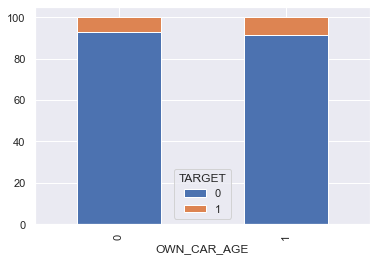

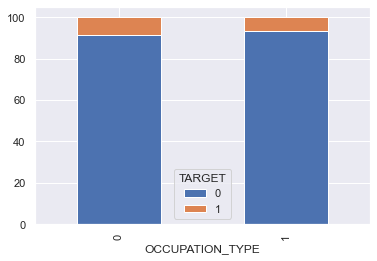

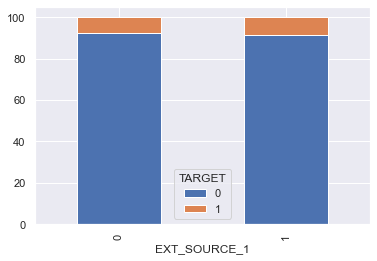

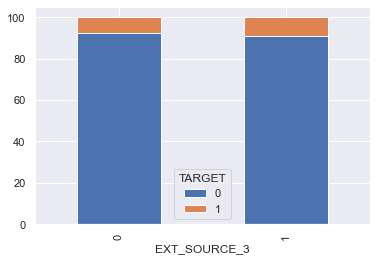

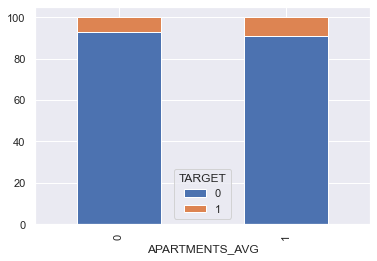

In [9]:
# Visually examine the na distribution a few example
for c in col_sig_na[:5]:
    df_plt = pd.crosstab(df_na['TARGET'], df_na[c]).apply(lambda c: c / c.sum() * 100)
    df_plt.T.plot(kind='bar', stacked=True)

## _"Repartition" Data Types_

Among the 122 columns, 106 of them are numeric and 16 are categorical (`object`). We can further divide the numerical columns into `float64` and `int64` columns. Float columns are regular scaler numeric features like `amt_income_total`. The composition of integer columns is more interesting,
* Indicator, e.g, `flag_own_car`
* Rating, e.g., `region_rating_client`
* Datetime, e.g., `weekday_appr_process_start`
* Count, e.g., `cnt_fam_members`

Some of these integer predictors has a discrete nature, such as rating. We can set the `flag, rating,` and `weekday` types of numerical features to categorical ones. 

In [10]:
# Select columns using regex
pat_flag = r'FLAG|REGION_NOT|CITY_NOT'
pat_week = r'WEEKDAY'
pat_rate = r'RATING'
col_ints = df_app.filter(regex=r'^(?!TARGET)').select_dtypes('int').columns
col_cats = df_app.select_dtypes('object').columns.append(
    df_app.loc[:, col_ints]
        .filter(regex=f'{pat_flag}|{pat_rate}|{pat_week}')
        .columns
)

### _Imputation & Numerical Encoding_

* For categorical data, we set the missing values as a separate factor level. Then, we use _[Weight of Evidence Encoding](https://contrib.scikit-learn.org/category_encoders/woe.html)_ (a supervised encoding method, which prevents category explosion problem faced by One-hot Encoding) to numericalize categorical variables.
* For numerical data, we impute the missing values by sample mean.

Note that we impute the values with entire dataset. But during model training, we need to redo the process __using training data only.__

In [11]:
# Fill NA categorical vars with a MISSING token
df_app.loc[:, col_cats] = (
    df_app.loc[:, col_cats]
        .astype('str')
        .fillna('[MISSING]')
        .astype('category')
)

# Int to floats
df_app.loc[:, col_ints] = df_app.loc[:, col_ints].astype('float')

# Numericalize pipeline
pipe_num = Pipeline([
    ('woe-encoding', WOEEncoder()),
    ('mean-impute', SimpleImputer()),
    ('std-scaler', StandardScaler())
])

df_eda = df_app.drop('TARGET', axis=1)
df_eda = pd.DataFrame(
    pipe_num.fit_transform(df_eda, df_app.TARGET), 
    columns=df_eda.columns,
    index=df_eda.index
).assign(TARGET=df_app.TARGET)
df_eda.head()

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
SK_ID_CURR                                                                   
100002                0.324395     1.387942      0.717914        -0.664531   
100003                0.324395    -0.720349      0.717914         1.504820   
100004               -3.082659     1.387942     -1.392925        -0.664531   
100006                0.324395    -0.720349      0.717914        -0.664531   
100007                0.324395     1.387942      0.717914        -0.664531   

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002         -0.577538          0.142129   -0.478095    -0.166149   
100003         -0.577538          0.426792    1.725450     0.592677   
100004         -0.577538         -0.427196   -1.152888    -1.404676   
100006         -0.577538         -0.142533   -0.711430     0.177869   
100007         -0.577538         -0.199466   -0.213734    -0.361755   

            AMT_GOODS_PRICE  NAME_TYPE_SUITE  ...  FLAG_DOCUMENT_19  \
SK_ID_CURR                                    ...                     
100002            -0.507465         0.329801  ...         -0.024402   
100003             1.600698        -1.708159  ...         -0.024402   
100004            -1.092389         0.329801  ...         -0.024402   
100006            -0.653696         0.329801  ...         -0.024402   
100007            -0.068772         0.329801  ...         -0.024402   

            FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_HOUR  \
SK_ID_CURR                                                                   
100002             -0.022529         -0.018305               -8.210023e-02   
100003             -0.022529         -0.018305               -8.210023e-02   
100004             -0.022529         -0.018305               -8.210023e-02   
100006             -0.022529         -0.018305                3.336720e-17   
100007             -0.022529         -0.018305               -8.210023e-02   

            AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
SK_ID_CURR                                                          
100002                      -0.067957               -1.805048e-01   
100003                      -0.067957               -1.805048e-01   
100004                      -0.067957               -1.805048e-01   
100006                       0.000000               -3.645032e-17   
100007                      -0.067957               -1.805048e-01   

            AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
SK_ID_CURR                                                         
100002                      -0.313873              -3.594746e-01   
100003                      -0.313873              -3.594746e-01   
100004                      -0.313873              -3.594746e-01   
100006                       0.000000              -7.516682e-17   
100007                      -0.313873              -3.594746e-01   

            AMT_REQ_CREDIT_BUREAU_YEAR  TARGET  
SK_ID_CURR                                      
100002                   -5.176655e-01       1  
100003                   -1.092866e+00       0  
100004                   -1.092866e+00       0  
100006                   -3.831603e-16       0  
100007                   -1.092866e+00       0  

[5 rows x 121 columns]

From the correlation heatmap below, we can see that strong linear correlation between predictors do exist. For instance, the correlation between different housing information is very strong, which is also intuitive: e.g., shared living area depends on overall living area. __Therefore, we may consider applying _PCA_ before fitting our model (especially for linear model like _Logistic Regression_).__

<AxesSubplot:>

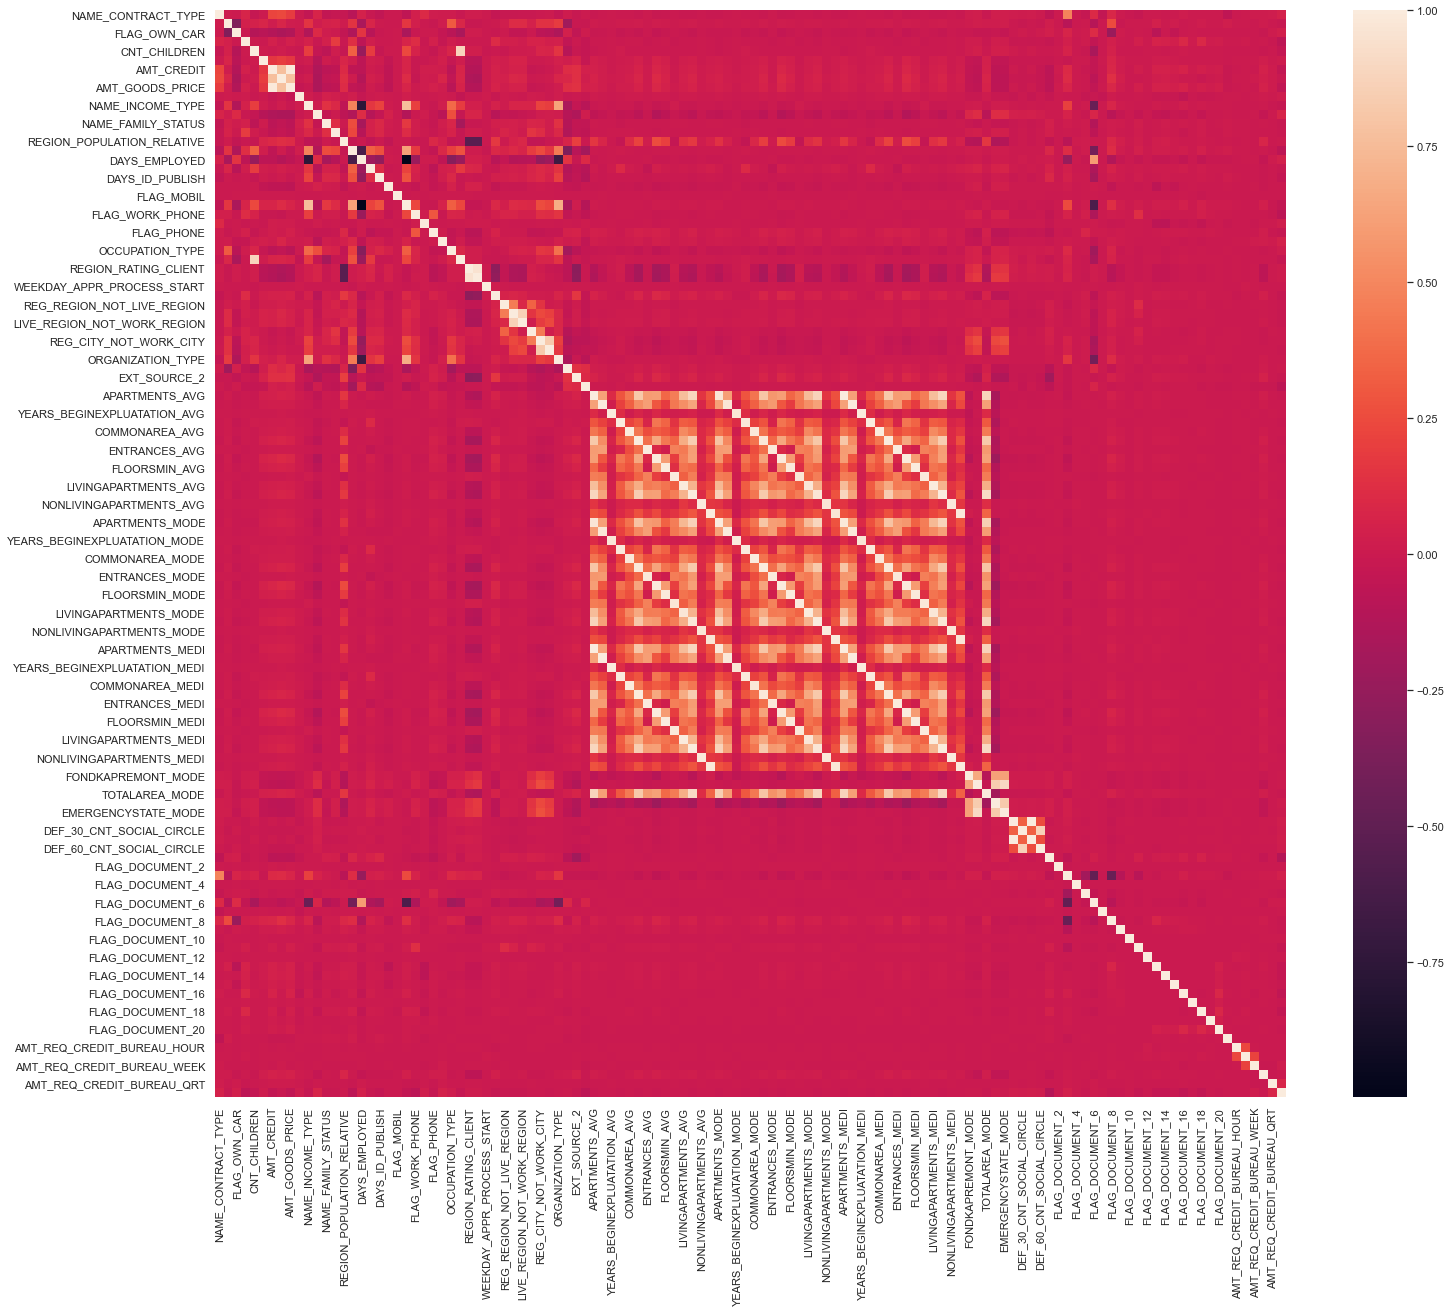

In [12]:
# Viz correlation
fig_corr, ax_corr = plt.subplots(1, 1, figsize=(24, 20))
sns.heatmap(df_eda.drop('TARGET', axis=1).corr(), ax=ax_corr)

### _PCA Dim-reduction_

With 64 principle components, which is half of the original dimension, we are able to explain roughly 92% of total variance. We then draw pairwise scatter plot to see if there is any interesting combinations of main components that can help separate default applicants. Due to the large data size, we sampled a subset from the full dataset to draw the scatter plots. From the bi-variate distribution plot, there does not seem to be any combination of PCs that can help separate good from bad.

In [13]:
model_pca = PCA(n_components=64, whiten=True)
df_eda = pd.DataFrame(
    model_pca.fit_transform(df_eda.drop('TARGET', axis=1)),
    index=df_eda.index
).assign(TARGET=df_eda.TARGET)
print(f'Variance explained with 64 PCs is {model_pca.explained_variance_ratio_.sum() * 100:.3f}%')

Variance explained with 64 PCs is 92.195%


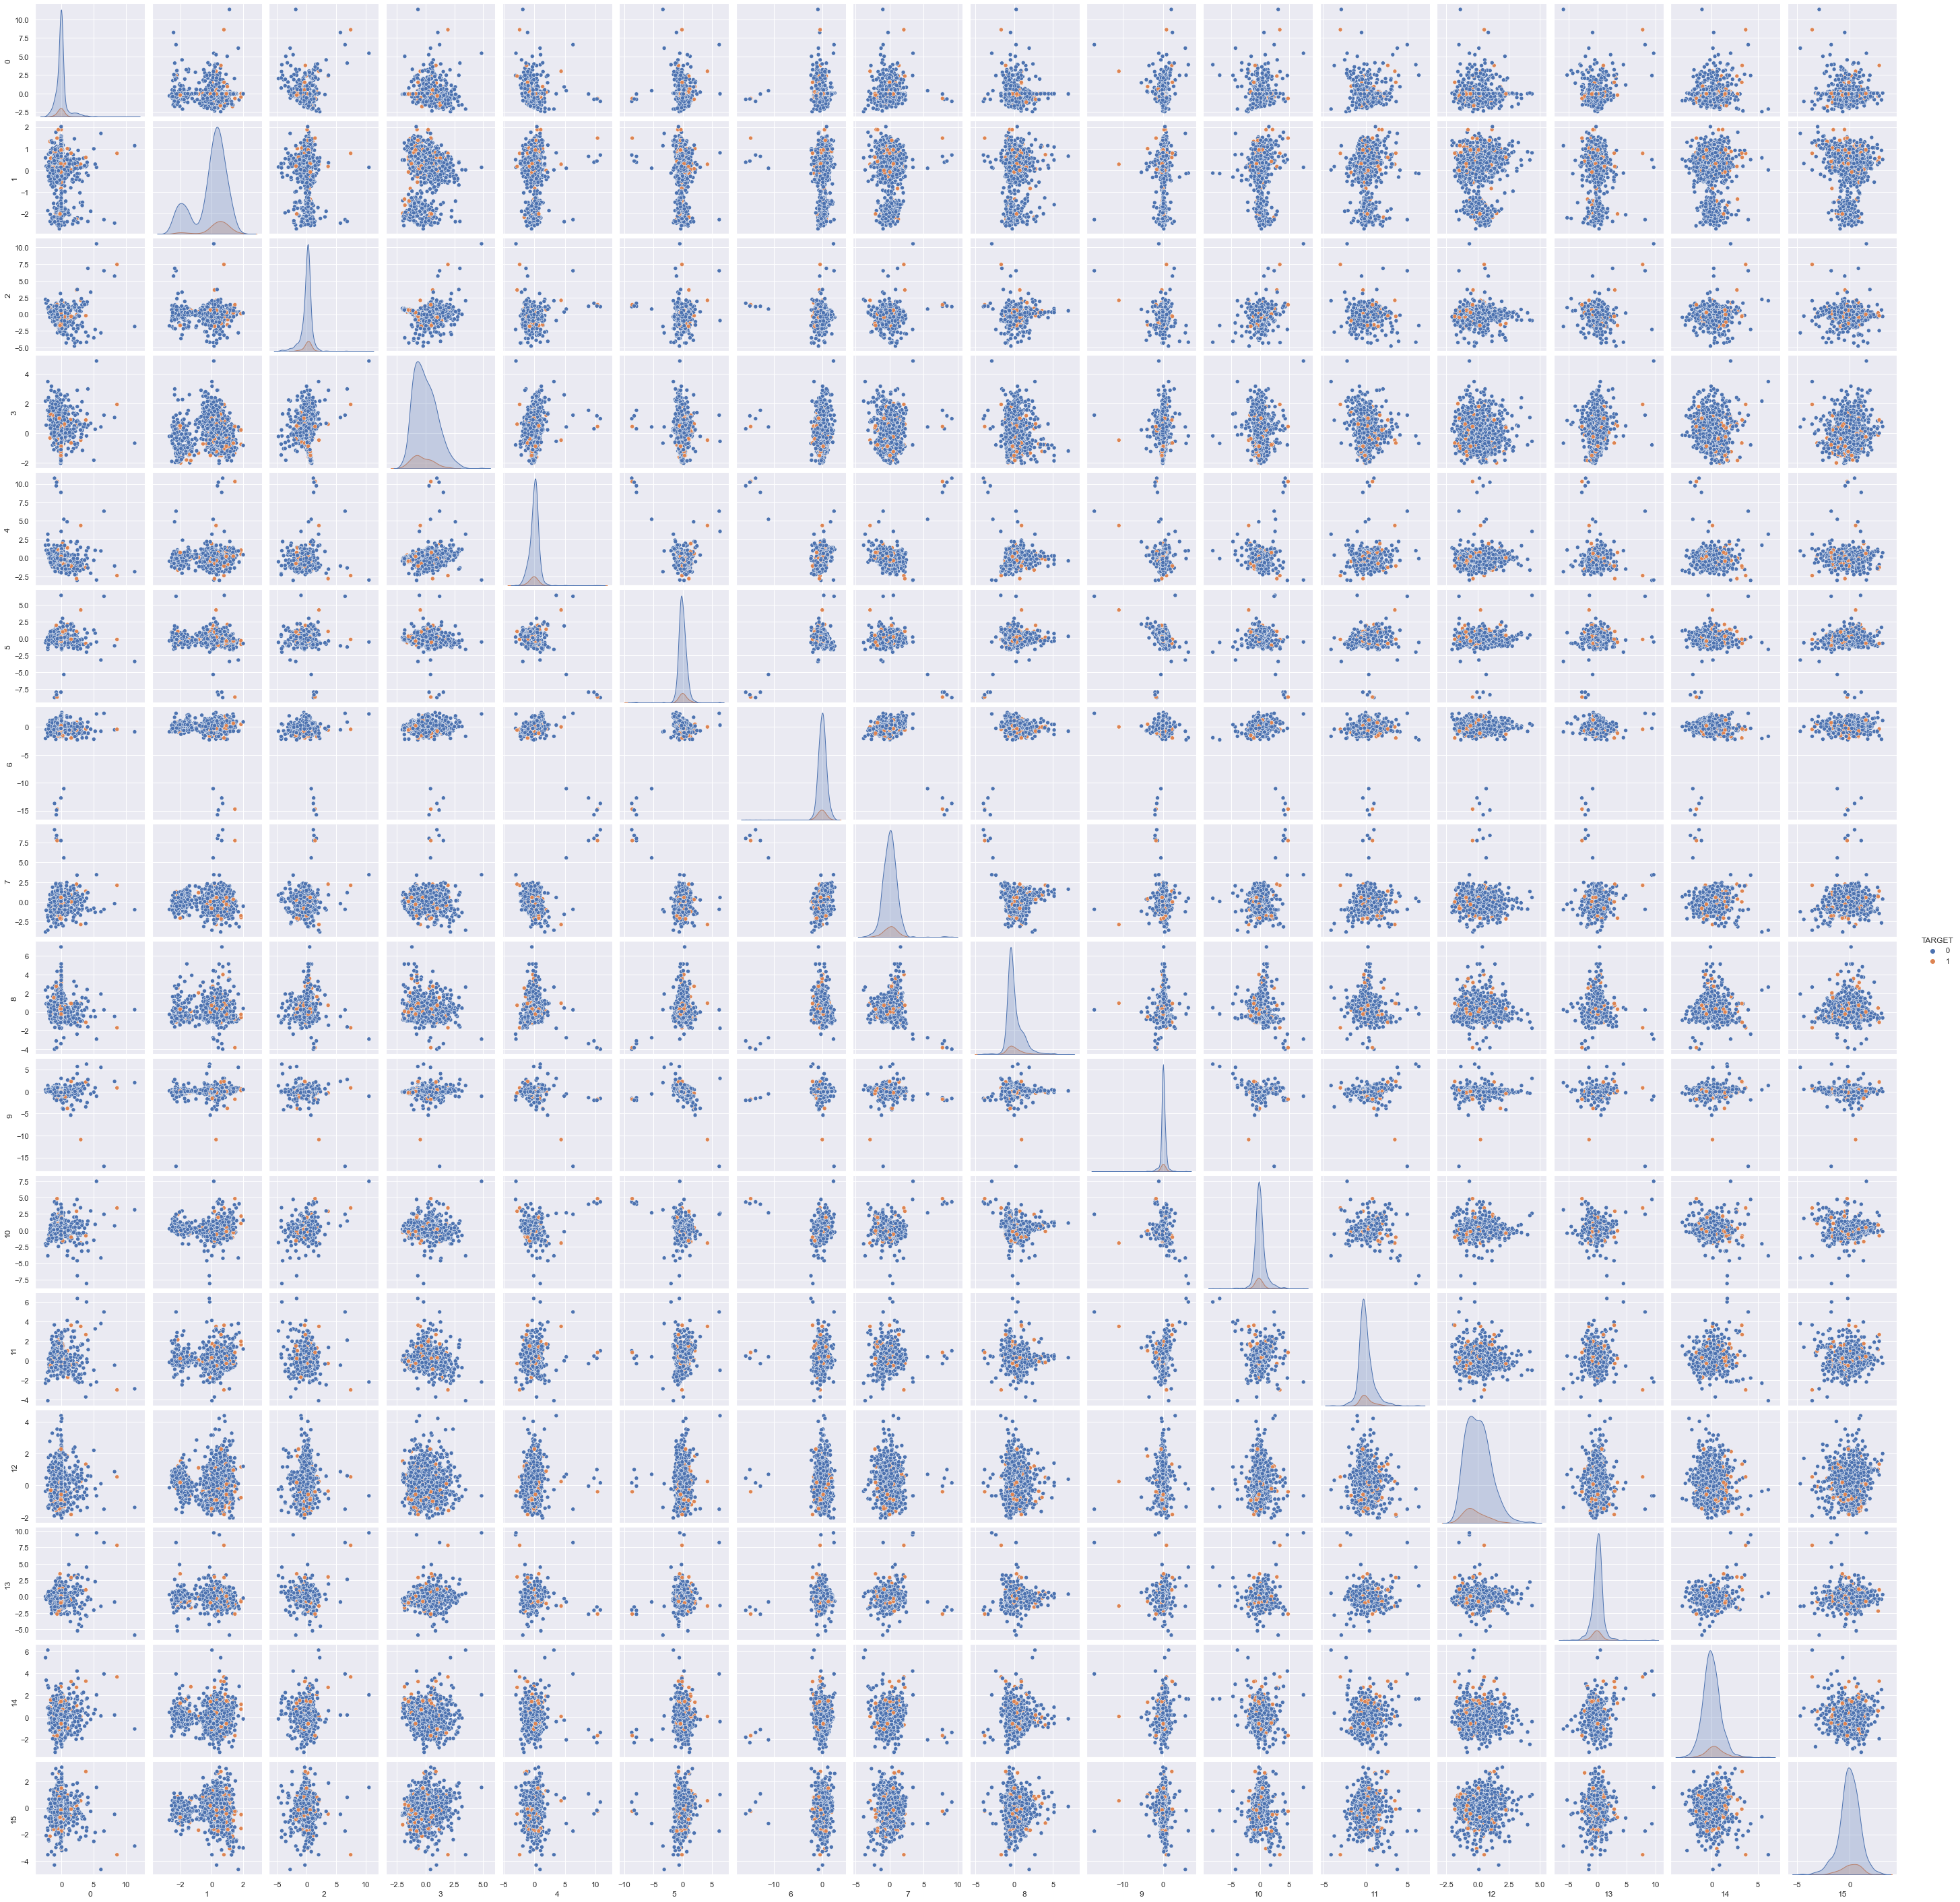

In [14]:
df_plt = df_eda.sample(1024)
df_plt = df_plt.iloc[:, :16].assign(TARGET=df_plt.TARGET)
sns.pairplot(df_plt, hue='TARGET')

In [15]:
del df_eda
del df_na

## __Model Training__

### _Train-test Partition_

We randomly select 20% of the sample data points as test data. The test data is only used for performance evaluation and __NEVER GO INTO TRAINING__. The hyper parameters are chosen empirically due to the large dataset size.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df_app.drop('TARGET', axis=1), df_app.loc[:, 'TARGET'],
    test_size=0.2,
    random_state=42
)

### _Data Pipeline and Model Definition_

In [17]:
# Prepare data
pipeline_app = Pipeline([
    ('woe-encoding', WOEEncoder()),
    ('mean-impute', SimpleImputer()),
    ('std-scaler', StandardScaler()),
    ('pca', PCA(n_components=64, whiten=True))
]).fit(X_train, y_train)

# Transform
X_train_mdl = pipeline_app.transform(X_train)
X_test_mdl = pipeline_app.transform(X_test)

# Model
model_app = LogisticRegression(
    penalty='elasticnet',  
    l1_ratio=0.8, 
    class_weight='balanced', 
    solver='saga'
).fit(X_train_mdl, y_train)

### _Quick Evaluation_

From the AUC below, we see that the result is satisfactory: 0.74 on both the training and testing dataset. There is no over-fitting problem.

In [18]:
p_train = model_app.predict_proba(X_train_mdl)[:, 1]
p_test = model_app.predict_proba(X_test_mdl)[:, 1]
print(f'Train auc {roc_auc_score(y_train, p_train):.3f}; test auc {roc_auc_score(y_test, p_test):.3f}')

Train auc 0.740; test auc 0.741


In [19]:
del X_train
del X_test
del y_train
del y_test
del X_train_mdl
del X_test_mdl

### _Retrain Model with Full Dataset_

This is the end of part one. Here we have constructed a full model `model_app` using all available training set. In the next part, we deal with bureau data.

In [20]:
pipeline_app.fit(df_app.drop('TARGET', axis=1), df_app.loc[:, 'TARGET'])
model_app.fit(pipeline_app.transform(df_app.drop('TARGET', axis=1)), df_app.loc[:, 'TARGET'])

LogisticRegression(class_weight='balanced', l1_ratio=0.8, penalty='elasticnet',
                   solver='saga')

In [21]:
df_app.loc[:, 'SCORE_APP'] = model_app.predict_proba(pipeline_app.transform(df_app.drop('TARGET', axis=1)))[:, 1]
print(f'Full dataset auc {roc_auc_score(df_app.loc[:, "TARGET"], df_app.loc[:, "SCORE_APP"]):.3f}')

Full dataset auc 0.740


In [22]:
# Store the prediction to an intermediate table
df_app.loc[:, ['SCORE_APP']].to_csv('combo-data/app_train_score.csv')

# Calculate score on test set and write to intermediate table as well
df_app_test = pd.read_csv('raw-data/application_test.csv', index_col='SK_ID_CURR')

# Fill NA categorical vars with a MISSING token
df_app_test.loc[:, col_cats] = (
    df_app_test.loc[:, col_cats]
        .astype('str')
        .fillna('[MISSING]')
        .astype('category')
)

# Int to floats
df_app_test.loc[:, col_ints] = df_app_test.loc[:, col_ints].astype('float')
df_app_test = df_app_test.assign(
    SCORE_APP=model_app.predict_proba(pipeline_app.transform(df_app_test))[:, 1]
)
df_app_test.loc[:, ['SCORE_APP']].to_csv('combo-data/app_test_score.csv')

In [23]:
del df_app_test
del df_app

# __Part II, Modeling with Credit Bureau Data__

In [24]:
# Load data
application_train = pd.read_csv("raw-data/application_train.csv", usecols=['SK_ID_CURR', 'TARGET'])
bureau = pd.read_csv("raw-data/bureau.csv")
bureau_balance = pd.read_csv("raw-data/bureau_balance.csv")

## __Data Overview__
### _Preliminary Analysis_
In this notebook we explore `bureau.csv` and `bureau_balance.csv`, which are the previous credits from other institutions and monthly balances of previous credits. There are 1716428 rows and 17 columns in `bureau.csv`, and 27299925 rows and 3 columns in `bureau_balance.csv`. Each row in `bureau.csv` represents a credit that a client had before application. Each row in `bureau_balance.csv` represents historical credit in each month. Besides IDs, each column in `bureau.csv` represents a feature, such as currency type and amount overdue, of the preivous credict.The columns in `bureau_balance.csv` represent ID, month of balance, and status of loan respectively.

In [25]:
# Check data dimensions
print("bureau:")
print("rows: ", bureau.shape[0], "columns: ", bureau.shape[1])
print("bureau_balance:")
print("rows: ", bureau_balance.shape[0], "columns: ", bureau_balance.shape[1])

bureau:
rows:  1716428 columns:  17
bureau_balance:
rows:  27299925 columns:  3


In [26]:
# Check bureau head
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [27]:
# Check bureau_balance head
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [28]:
# Check bureau columns values
bureau.columns.values

array(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'], dtype=object)

In [29]:
# Check bureau_balance columns values
bureau_balance.columns.values

array(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype=object)

### _Missing Value Detection_
We check the amount of missing data in the two dataset. As the output results indicated, there is no missing data in `bureau_balance.csv`, whereas 6 columns, which are all numerical values, of `bureau.csv` have missing data. Therefore, data imputation will be performend later in this section after having a more in-depth understanding of the dataset.

In [30]:
# Count missing data
print("bureau missing data count:\n", bureau.isnull().sum().sort_values(ascending = False))
print("\n\nbureau_balance missing data count:\n", bureau_balance.isnull().sum().sort_values(ascending = False))

bureau missing data count:
 AMT_ANNUITY               1226791
AMT_CREDIT_MAX_OVERDUE    1124488
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_DEBT        257669
DAYS_CREDIT_ENDDATE        105553
AMT_CREDIT_SUM                 13
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
SK_ID_BUREAU                    0
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
SK_ID_CURR                      0
dtype: int64


bureau_balance missing data count:
 SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


## __Data Visualization and Feature Selection__
### _Merging with Application Data_
To visualize and analyze bureau data, we need to merge it with `application_train.csv` to get the `TARGET` value for each `SK_ID_CURR` in bureau data. Since application_train data is analyzed thoroughly in previous section, we will just do some basic exploration on it to get some fundamental understanding.

In [31]:
# Check application_train dimensions
print("application_train:")
print("rows: ", application_train.shape[0], "columns: ", application_train.shape[1])

application_train:
rows:  307511 columns:  2


In [32]:
# Check application_train head
application_train.head()

SK_ID_CURR  TARGET
0      100002       1
1      100003       0
2      100004       0
3      100006       0
4      100007       0

In [33]:
# Check application_train columns values
application_train.columns.values

array(['SK_ID_CURR', 'TARGET'], dtype=object)

As the columns of application data indicates, a common identifier for bureau data and application data is `SK_ID_CURR`. Therefore, a inner join can be performed on `SK_ID_CURR`.

In [34]:
# Join application_train and bureau for analysis
merged_application_train_bureau_query = """
    SELECT *
    FROM application_train
    INNER JOIN bureau
    ON application_train.SK_ID_CURR = bureau.SK_ID_CURR
"""
application_train_bureau = ps.sqldf(merged_application_train_bureau_query)

In [35]:
print("application_train_bureau:")
print("rows: ", application_train_bureau.shape[0], "columns: ", application_train_bureau.shape[1])

application_train_bureau:
rows:  1465325 columns:  19


In [36]:
# Check application_train_bureau head
application_train_bureau.head()

SK_ID_CURR  TARGET  SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  \
0      100002       1      100002       6113835        Closed      currency 1   
1      100002       1      100002       6158903        Active      currency 1   
2      100002       1      100002       6158904        Closed      currency 1   
3      100002       1      100002       6158905        Closed      currency 1   
4      100002       1      100002       6158906        Closed      currency 1   

   DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0        -1043                   0                 62.0             -967.0   
1        -1042                   0                780.0                NaN   
2        -1125                   0              -1038.0            -1038.0   
3         -476                   0                  NaN              -48.0   
4        -1437                   0              -1072.0            -1185.0   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     0.0                   0         67500.0   
1                     NaN                   0        450000.0   
2                     NaN                   0         40761.0   
3                     NaN                   0             0.0   
4                     0.0                   0        135000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  NaN                   NaN                     0.0   
1             245781.0                   0.0                     0.0   
2                  NaN                   NaN                     0.0   
3                  0.0                   NaN                     0.0   
4                  0.0                   0.0                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0      Credit card                -758          0.0  
1  Consumer credit                  -7          0.0  
2      Credit card               -1038          0.0  
3      Credit card                 -47          NaN  
4  Consumer credit               -1185          0.0

### _Feature Selection and Visualization_
After merging the two datasets, we can now do visualization and in-depth analysis on the data. Firstly, according to governance information provided in `HomeCredit_columns_description.csv`, we pre-select some columns, including `CREDIT_ACTIVE`, `CREDIT_CURRENCY`, `CREDIT_TYPE`, `DAYS_CREDIT`, `CREDIT_DAY_OVERDUE`, `AMT_CREDIT_SUM`, and `AMT_CREDIT_SUM_LIMIT`, that are more related to our desired output, `TARGET`. No columns from `bureau_balance.csv` is selected since they are not suitable for our objective based on their descriptions.

In [37]:
# Define plotting function
def plot_feature(feature, horizontal, label_rot):
    feature_contract_pd = pd.DataFrame({feature: application_train_bureau[feature].value_counts().index,\
                                        'Number of Contracts': application_train_bureau[feature].value_counts().values})

    target_category = application_train_bureau[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    target_category.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,15))
    sns.set_color_codes('colorblind')
    
    sns_plot = sns.barplot(ax=ax1, x = feature, y='Number of Contracts',data=feature_contract_pd)
    
    if(label_rot):
        sns_plot.set_xticklabels(sns_plot.get_xticklabels(),rotation=90)
    
    sns_plot = sns.barplot(ax=ax2, x = feature, y='TARGET', order=target_category[feature], data=target_category)
    
    if(label_rot):
        sns_plot.set_xticklabels(sns_plot.get_xticklabels(),rotation=90)
        
    plt.ylabel('TARGET 1 in Percentage', fontsize=9)
    plt.tick_params(axis='both', which='major', labelsize=9)

    plt.show()

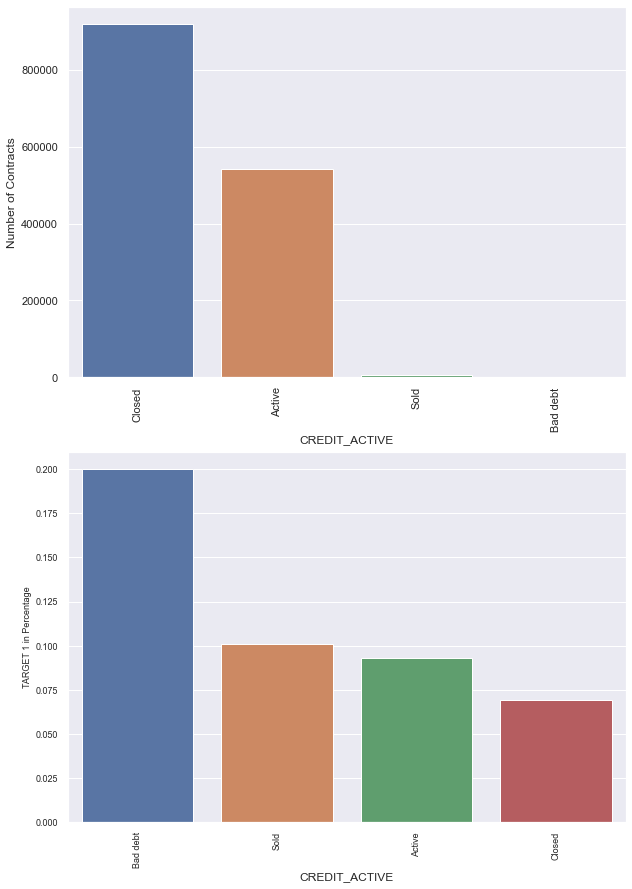

In [38]:
# Plot credit status distribution
plot_feature('CREDIT_ACTIVE', False, True)

Firstly, the `CREDIT_ACTIVE`, which is the status of the Credit Bureau reported credits, is plotted with categories of Closed, Active, Sold, and Bad debt. As the plot indicates, most of the data is in Closed and Active. Few is in Sold and Bad debt.

After linking the `CREDIT_ACTIVE` to `TARGET` = 1, it is noticeable that Sold, Active, and Closed are less than 10%, with Closed being the lowest, whereas Bad debt has about 20%. The two times difference between Bad debt and other categories indicates that `CREDIT_ACTIVE` relates to `TARGET` = 1 strongly.

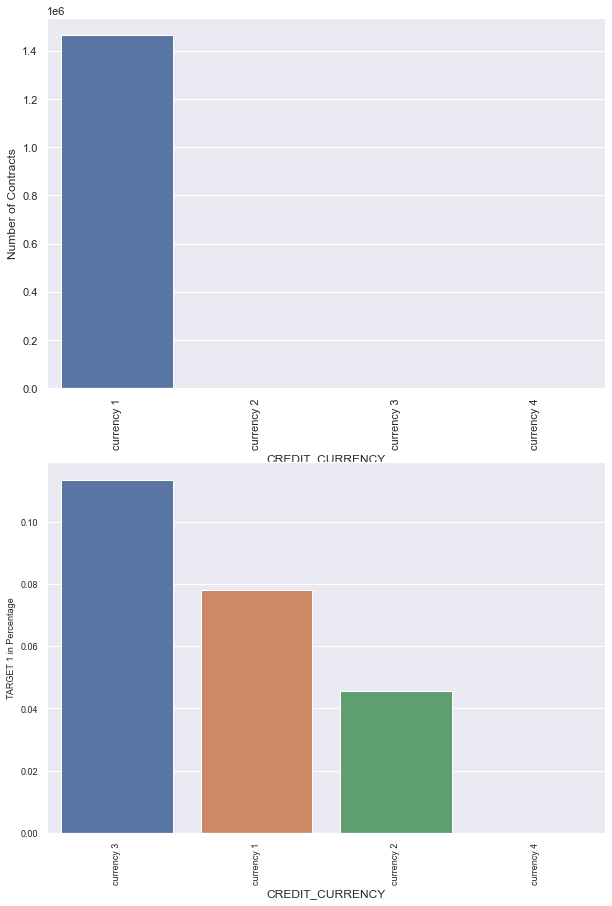

In [39]:
# Plot the number of credits with different currencies and percentage of default credits per different currencies
plot_feature('CREDIT_CURRENCY', False, True)

The `CREDIT_CURRENCY`, which is the recorded currency of the Credit Bureau credit, is plotted  with different currencies. Most contracts are in currenty 1. When relating to `TARGET` = 1, currency 3 has the most amount of data in `TARGET` = 1, which is above 10%. Currency 1 and currency 2 has relatively lower percentage, which are about 8% and 4.5% respectively. Currency 4 is almost 0.

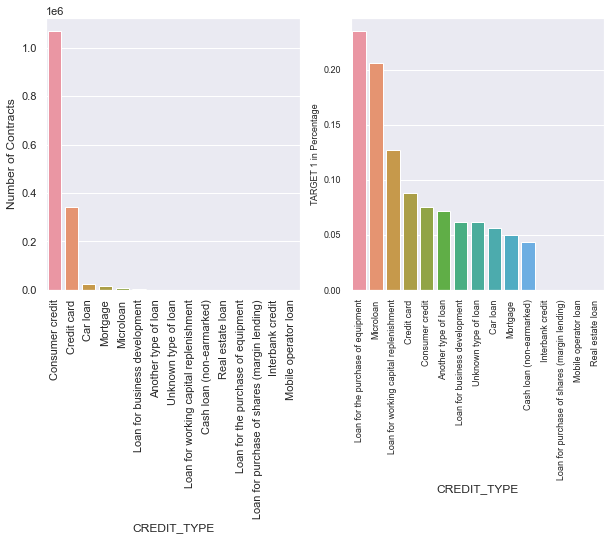

In [40]:
# Plot credit types
plot_feature('CREDIT_TYPE', True, True)

The `CREDIT_TYPE`, which is the type of Credit Bureau credit, is then plotted. According to the plot, most of the contracts are Consumer credit and Credit card. The following are Car loan, Mortgage, and Microloan. The rest are barely noticeable. When plotting against `TARGET` = 1, the top percentages are Loan for puchase of equipment and Microloan, which are above 20%. Loan for working capital replenishment is above 10%. Credit card, Consumer credit, Another type of loan, Loan for business development, Unknown type of loan, Car loan, Mortgage, and Cash loan are within the range of 0% to 10%. The rest types are barely noticeable 

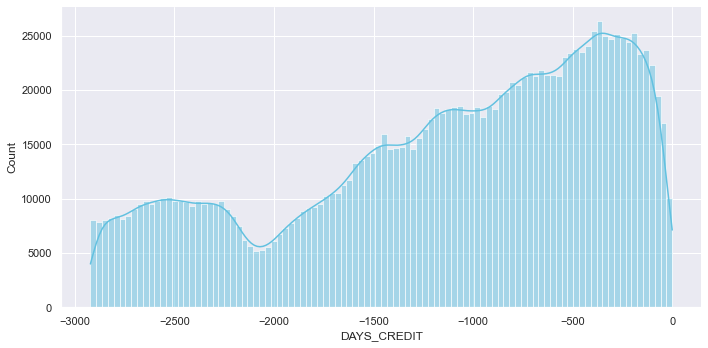

In [41]:
# Distribution of DAYS_CREDIT
sns.displot(application_train_bureau['DAYS_CREDIT'].dropna(),color='#62c1e0', kde=True,bins=100, height=5, aspect=2)
plt.show()

The distribution of `DAYS_CREDIT`, which is the days that the client apply for Credit Bureau credit before current application and is time only relative to the application, is counted and plotted. It generally shows a increasing trend as `DAYS_CREDIT` becomes smaller, with a maximum between -500 and 0.

In [42]:
def detect_outlier_val(pts_df, threshold=3.5):
    if len(pts_df.shape) == 1:
        pts = pts_df.to_numpy()[:,None]
    median = np.median(pts, axis=0)
    diff = np.sum((pts - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > threshold

In [43]:
def displot_no_outlier(plotted_feature,plotted_color):
    dropped_value = application_train_bureau[plotted_feature].dropna()
    filtered_value = dropped_value[~detect_outlier_val(dropped_value)]
    sns.displot(filtered_value,color=plotted_color, kde=True,bins=100, height=5, aspect=2)
    plt.show()

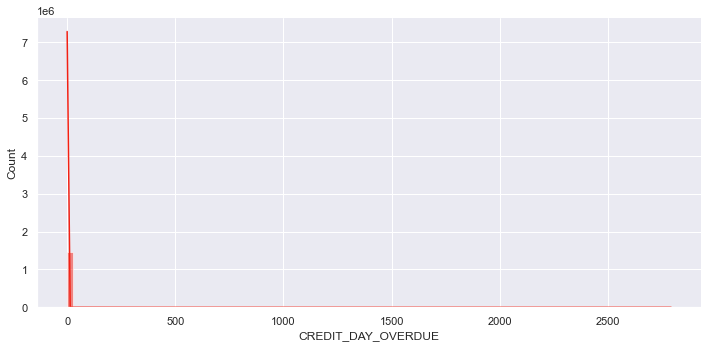

In [44]:
# Distribution of CREDIT_DAY_OVERDUE
sns.displot(application_train_bureau['CREDIT_DAY_OVERDUE'].dropna(),color='#f32013', kde=True,bins=100, height=5, aspect=2)
plt.show()

The distribution of `CREDIT_DAY_OVERDUE`, which is the number of days past due on Credit Bureau credit at the time of application for related loan in the sample, is plotted. As the plot shows, the majority is around 0 `CREDIT_DAY_OVERDUE`.

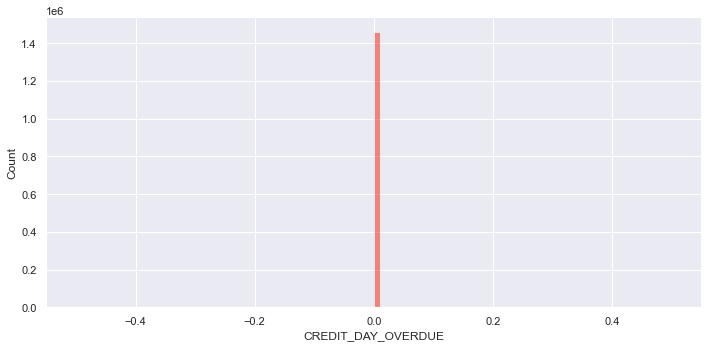

In [45]:
displot_no_outlier('CREDIT_DAY_OVERDUE','#f32013')

To make sure no outlier affects the observation, the outliers are eliminated and the distribution is replotted. As the new plot without outlier indicates, the majority is indeed around 0.

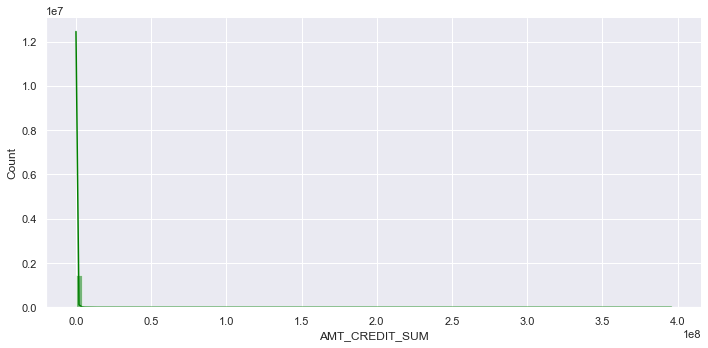

In [46]:
# Distribution of AMT_CREDIT_SUM
sns.displot(application_train_bureau['AMT_CREDIT_SUM'].dropna(),color='#008000', kde=True,bins=100, height=5, aspect=2)
plt.show()

The distribution of `AMT_CREDIT_SUM`, which is the current credit amount for the Credit Bureau credit, is plotted. The majority is also around 0.

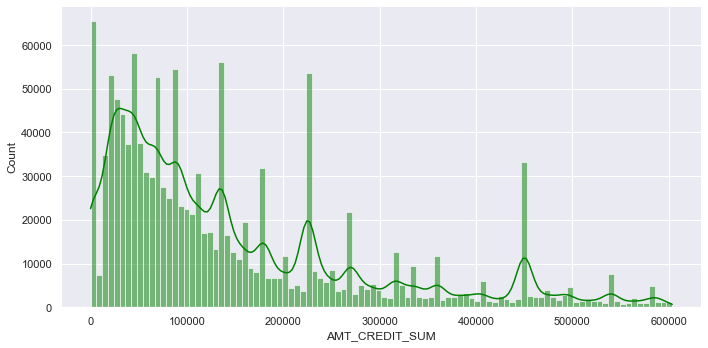

In [47]:
displot_no_outlier('AMT_CREDIT_SUM','#008000')

Similarly, to make sure no outlier affects the observation, the outliers are eliminated and the distribution is replotted. The new plot shows the trend of `AMT_CREDIT_SUM` in more detail. As the new plot indicates, it is generally a downward trend, with the global maximum bat around 50000 and several local extrema.

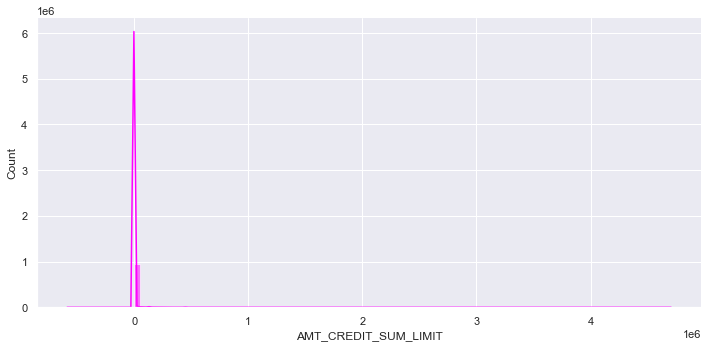

In [48]:
# Distribution of AMT_CREDIT_SUM_LIMIT
sns.displot(application_train_bureau['AMT_CREDIT_SUM_LIMIT'].dropna(),color='#FF00FF', kde=True,bins=100, height=5, aspect=2)
plt.show()

The distribution of `AMT_CREDIT_SUM_LIMIT`, which is the current credit limit of credit card reported in Credit Bureau, is plotted. As the plot shows, the majority is around 0 `AMT_CREDIT_SUM_LIMIT`.

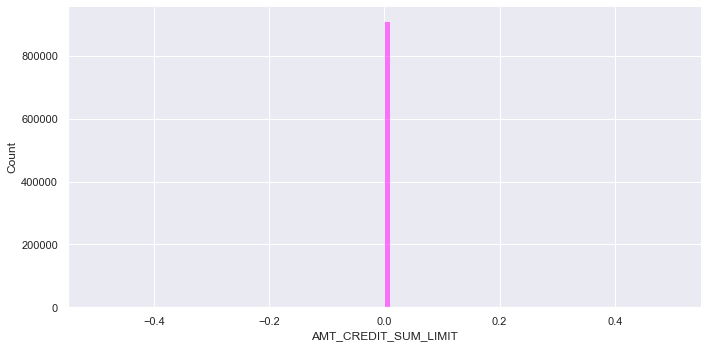

In [49]:
displot_no_outlier('AMT_CREDIT_SUM_LIMIT','#FF00FF')

To make sure no outlier affects the observation, the outliers are eliminated and the distribution is replotted. As the new plot without outlier indicates, the majority is indeed around 0.

<Figure size 432x288 with 0 Axes>

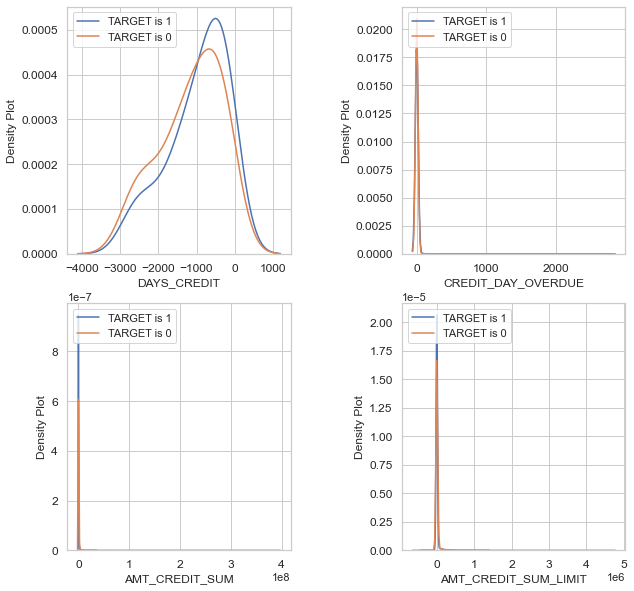

In [50]:
## Compare the distribution of interval values with TARGET of 0 and 1
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2, 2,figsize=(10,5 * 2))

target0 = application_train_bureau.loc[application_train_bureau['TARGET'] == 0]
target1 = application_train_bureau.loc[application_train_bureau['TARGET'] == 1]

count = 0

features = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT']

for feature in features:
    count += 1
    plt.subplot(2, 2,count)
    sns.kdeplot(target1[feature], bw_method=0.5,label='TARGET is 1')
    sns.kdeplot(target0[feature], bw_method=0.5,label='TARGET is 0')
    plt.ylabel('Density Plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='upper left')
plt.subplots_adjust(wspace=.5)
plt.show()

Comparisons of distributions of `DAYS_CREDIT`, `CREDIT_DAY_OVERDUE`, `AMT_CREDIT_DUM`, and `AMT_CREDIT_SUM_LIMIT` with respect to `TARGET` 1 and `TARGET` 0 are plotted above. As the plots indicate, the plotted features shows different behaviors when `TARGET` is different value. Therefore, they can be used to predict whether a `TARGET` value is 0 or 1.

## __Wrangling & Feature Engineering__
### _Imputation_
We then process the selected feature columns and prepare data for training. We found several columns in the dataset that have null value when overview the data. Now, we need to do imputation on these columns. Numerical missing data are filled in using imputation by mean. There is no need for imputation on categorical data since no missing value was found on categorical data. 

In [51]:
# Data imputation using mean value
imputed_bureau = bureau
imputed_bureau["AMT_ANNUITY"].fillna(imputed_bureau["AMT_ANNUITY"].mean(), inplace=True)
imputed_bureau["AMT_CREDIT_MAX_OVERDUE"].fillna(imputed_bureau["AMT_CREDIT_MAX_OVERDUE"].mean(), inplace=True)
imputed_bureau["DAYS_ENDDATE_FACT"].fillna(imputed_bureau["DAYS_ENDDATE_FACT"].mean(), inplace=True)
imputed_bureau["AMT_CREDIT_SUM_LIMIT"].fillna(imputed_bureau["AMT_CREDIT_SUM_LIMIT"].mean(), inplace=True)
imputed_bureau["AMT_CREDIT_SUM_DEBT"].fillna(imputed_bureau["AMT_CREDIT_SUM_DEBT"].mean(), inplace=True)
imputed_bureau["DAYS_CREDIT_ENDDATE"].fillna(imputed_bureau["DAYS_CREDIT_ENDDATE"].mean(), inplace=True)
imputed_bureau["AMT_CREDIT_SUM"].fillna(imputed_bureau["AMT_CREDIT_SUM"].mean(), inplace=True)

In [52]:
# Double check if there is missing data
print("bureau missing data count:\n", imputed_bureau.isnull().sum().sort_values(ascending = False))
print("\n\nbureau_balance missing data count:\n", bureau_balance.isnull().sum().sort_values(ascending = False))

bureau missing data count:
 SK_ID_CURR                0
CNT_CREDIT_PROLONG        0
DAYS_CREDIT_UPDATE        0
CREDIT_TYPE               0
AMT_CREDIT_SUM_OVERDUE    0
AMT_CREDIT_SUM_LIMIT      0
AMT_CREDIT_SUM_DEBT       0
AMT_CREDIT_SUM            0
AMT_CREDIT_MAX_OVERDUE    0
SK_ID_BUREAU              0
DAYS_ENDDATE_FACT         0
DAYS_CREDIT_ENDDATE       0
CREDIT_DAY_OVERDUE        0
DAYS_CREDIT               0
CREDIT_CURRENCY           0
CREDIT_ACTIVE             0
AMT_ANNUITY               0
dtype: int64


bureau_balance missing data count:
 SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


In [53]:
# Average features
average_imputed_bureau = imputed_bureau.groupby('SK_ID_CURR').mean().reset_index()

In [54]:
# Check average_imputed_bureau dimensions
print("average_imputed_bureau:\n")
print("rows: ", average_imputed_bureau.shape[0], "columns: ", average_imputed_bureau.shape[1], "\n")

average_imputed_bureau:

rows:  305811 columns:  14 



In [55]:
# Check average_imputed_bureau head
average_imputed_bureau.head()

SK_ID_CURR  SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0      100001   5896633.000  -735.000000                 0.0   
1      100002   6153272.125  -874.000000                 0.0   
2      100003   5885878.500 -1400.750000                 0.0   
3      100004   6829133.500  -867.000000                 0.0   
4      100005   6735201.000  -190.666667                 0.0   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0            82.428571        -907.758778             3825.417661   
1          -134.120659        -777.484287             2485.174748   
2          -544.500000       -1077.359287                0.000000   
3          -488.500000        -532.500000             1912.708831   
4           439.333333        -719.291432             2550.278441   

   CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
0                 0.0   207623.571429         85240.928571   
1                 0.0   108131.945625         82129.544982   
2                 0.0   254350.125000             0.000000   
3                 0.0    94518.900000             0.000000   
4                 0.0   219042.000000        189469.500000   

   AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
0            889.930711                     0.0          -93.142857   
1           7113.328115                     0.0         -499.875000   
2         202500.000000                     0.0         -816.000000   
3              0.000000                     0.0         -532.000000   
4              0.000000                     0.0          -54.333333   

    AMT_ANNUITY  
0   3545.357143  
1   1964.094713  
2  15712.757700  
3  15712.757700  
4   1420.500000

In [56]:
average_imputed_bureau['count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_train = application_train[['SK_ID_CURR', 'TARGET']].\
                            merge(right=average_imputed_bureau[['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',\
                                                                'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_LIMIT']], how='inner', on='SK_ID_CURR')

In [57]:
# Check bureau_train dimensions
print("bureau_train:\n")
print("rows: ", bureau_train.shape[0], "columns: ", bureau_train.shape[1], "\n")

bureau_train:

rows:  263491 columns:  6 



In [58]:
# Check bureau_train head
bureau_train.head()

SK_ID_CURR  TARGET  DAYS_CREDIT  CREDIT_DAY_OVERDUE  AMT_CREDIT_SUM  \
0      100002       1  -874.000000                 0.0   108131.945625   
1      100003       0 -1400.750000                 0.0   254350.125000   
2      100004       0  -867.000000                 0.0    94518.900000   
3      100007       0 -1149.000000                 0.0   146250.000000   
4      100008       0  -757.333333                 0.0   156148.500000   

   AMT_CREDIT_SUM_LIMIT  
0           7113.328115  
1         202500.000000  
2              0.000000  
3              0.000000  
4              0.000000

### _One-Hot Encoding_
After filling in the null values, we need to perform one-hot encoding on categorical data. Firstly, we define a function that can take a column of categorical data and ID as input, and output a vector for each ID. Then, we apply the function on our selected categorical feature, which are `CREDIT_ACTIVE`, `CREDIT_CURRENCY`, and `CREDIT_TYPE`. Finally, the one-hot encoded features are merged with the imputed bureau dataset. 

In [59]:
# Define function for one hot encoding vectors
def one_hot_encoded_vector(dtf, SK_ID_CURR, feature):
    get_dummies_df = pd.get_dummies(dtf, columns=[feature])
    agg_vectors = {}
    for n, g in get_dummies_df.groupby(SK_ID_CURR):
        gp = g[g.columns[(g.columns).str.startswith(feature)]]
        agg_vector = np.matrix(gp).sum(axis=0)
        agg_vectors[n] = np.squeeze(np.asarray(agg_vector))
    agg_vectors_df = pd.DataFrame.from_dict(agg_vectors, orient="index")
    agg_vectors_df.columns = get_dummies_df.columns.values[get_dummies_df.columns.str.startswith(feature)]
    agg_vectors_df.index.names = ['SK_ID_CURR']
    return agg_vectors_df.reset_index()

In [60]:
# One-hot encoding for CREDIT_ACTIVE, CREDIT_CURRENCY, CREDIT_TYPE
credit_active_for_encoding = imputed_bureau[['SK_ID_CURR', 'CREDIT_ACTIVE']]
credit_currency_for_encoding = imputed_bureau[['SK_ID_CURR', 'CREDIT_CURRENCY']]
credit_type_for_encoding = imputed_bureau[['SK_ID_CURR', 'CREDIT_TYPE']]

credit_active_encoded = one_hot_encoded_vector(credit_active_for_encoding, 'SK_ID_CURR', 'CREDIT_ACTIVE')
credit_currency_encoded = one_hot_encoded_vector(credit_currency_for_encoding, 'SK_ID_CURR', 'CREDIT_CURRENCY')
credit_type_encoded = one_hot_encoded_vector(credit_type_for_encoding, 'SK_ID_CURR', 'CREDIT_TYPE')

In [61]:
# Merge one-hot encoded features
bureau_train = bureau_train.merge(right=credit_active_encoded, how='left', on='SK_ID_CURR')
bureau_train = bureau_train.merge(right=credit_currency_encoded, how='left', on='SK_ID_CURR')
bureau_train = bureau_train.merge(right=credit_type_encoded, how='left', on='SK_ID_CURR')

In [62]:
bureau_train
# Check bureau_train dimensions again
print("bureau_train:\n")
print("rows: ", bureau_train.shape[0], "columns: ", bureau_train.shape[1], "\n")

bureau_train:

rows:  263491 columns:  29 



In [63]:
# Check bureau_train head again
bureau_train.head()

SK_ID_CURR  TARGET  DAYS_CREDIT  CREDIT_DAY_OVERDUE  AMT_CREDIT_SUM  \
0      100002       1  -874.000000                 0.0   108131.945625   
1      100003       0 -1400.750000                 0.0   254350.125000   
2      100004       0  -867.000000                 0.0    94518.900000   
3      100007       0 -1149.000000                 0.0   146250.000000   
4      100008       0  -757.333333                 0.0   156148.500000   

   AMT_CREDIT_SUM_LIMIT  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  \
0           7113.328115                     2                       0   
1         202500.000000                     1                       0   
2              0.000000                     0                       0   
3              0.000000                     0                       0   
4              0.000000                     1                       0   

   CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold  ...  \
0                     6                   0  ...   
1                     3                   0  ...   
2                     2                   0  ...   
3                     1                   0  ...   
4                     2                   0  ...   

   CREDIT_TYPE_Interbank credit  CREDIT_TYPE_Loan for business development  \
0                             0                                          0   
1                             0                                          0   
2                             0                                          0   
3                             0                                          0   
4                             0                                          0   

   CREDIT_TYPE_Loan for purchase of shares (margin lending)  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   CREDIT_TYPE_Loan for the purchase of equipment  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   CREDIT_TYPE_Loan for working capital replenishment  CREDIT_TYPE_Microloan  \
0                                                  0                       0   
1                                                  0                       0   
2                                                  0                       0   
3                                                  0                       0   
4                                                  0                       0   

   CREDIT_TYPE_Mobile operator loan  CREDIT_TYPE_Mortgage  \
0                                 0                     0   
1                                 0                     0   
2                                 0                     0   
3                                 0                     0   
4                                 0                     0   

   CREDIT_TYPE_Real estate loan  CREDIT_TYPE_Unknown type of loan  
0                             0                                 0  
1                             0                                 0  
2                             0                                 0  
3                             0                                 0  
4                             0                                 0  

[5 rows x 29 columns]

## __Modeling Training__
### _PCA and Preliminary Model Evaluation_
After preparing the training data, now it is time to train a logistic regression model with bureau data. Firstly, the `bureau_train` dataset we prepared in previous steps is separated into feature data and labels. Then, PCA is performed to reduce correlation. But before doing PCA, we need to figure out the number of components to use by finding the flatting out point.

In [64]:
# Prepare input and output
X = bureau_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = bureau_train[['TARGET']]

In [65]:
# Fit PCA on all components to find the flatting out point
scaled_X = StandardScaler().fit_transform(X)
pca_variance = PCA(n_components=X.shape[1])
pca_variance_x = pca_variance.fit_transform(scaled_X)
pca_variance.explained_variance_ratio_

array([1.38367510e-01, 5.55814301e-02, 4.79706170e-02, 4.32631525e-02,
       4.05411833e-02, 3.92687128e-02, 3.83019353e-02, 3.77685029e-02,
       3.74680482e-02, 3.71489623e-02, 3.70812039e-02, 3.70405013e-02,
       3.70213607e-02, 3.69831362e-02, 3.68506278e-02, 3.65940264e-02,
       3.61015957e-02, 3.57929794e-02, 3.49174113e-02, 3.48019044e-02,
       3.27175534e-02, 3.00032186e-02, 2.48867247e-02, 2.17334185e-02,
       1.17942832e-02, 6.89505952e-32, 3.22424339e-32])

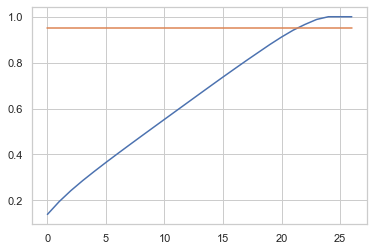

In [66]:
plt.plot(np.arange(0, 27), np.cumsum(pca_variance.explained_variance_ratio_))
plt.plot(np.arange(0, 27), [0.95]*27)
plt.show()

As we can see from the plot above, the curve becomes flat when the number of components is around 24. Therefore, we will use 24 as the number of components when doing the modeling. We firstly define a pipeline that just scale the data, perform PCA with number of components being 24, and fit a generic logistic regression on it to have a preliminary understanding of the model performance.

In [67]:
# Define pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dimensions', PCA(n_components=24)),
    ('lr', LogisticRegression()
)])

pipe.fit(X, y.values.ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ('reduce_dimensions', PCA(n_components=24)),
                ('lr', LogisticRegression())])

In [68]:
roc_auc_score(y, pipe.predict_proba(X)[:, 1])

0.6292597152292441

As the AUC score, which is about 0.629, indicates, the result is satisfactory. After confirming the result meets our expectation, we then use Grid Search to find the best combination of hyperparameters.

In [69]:
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dimensions', PCA(n_components=24))
])

In [70]:
grid_val = {
    'penalty': ['l1','l2','elasticnet'],
    'C': [0.001,.009,0.01,.09,1,5,10,25],
    'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]
}

clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid=grid_val, scoring='roc_auc')

X_PCA = pipe_pca.fit_transform(X)
gs_result = grid.fit(X_PCA, y.values.ravel())
print('Best Params from GridSearchCV: ', gs_result.best_params_)

Best Params from GridSearchCV:  {'C': 25, 'l1_ratio': 0, 'penalty': 'l2'}


### _Final Bureau Model Training_
The result from Grid Search indicates we should train a Ridge Regression with L2 penalty and inverse of regularization strength being 25. We then train the final bureau model based on this combination of hyperparameters.

In [71]:
final_bureau_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dimensions', PCA(n_components=24)),
    ('lr', LogisticRegression(C=25, penalty='l2'))
])

final_bureau_pipe.fit(X, y.values.ravel())
roc_auc_score(y, final_bureau_pipe.predict_proba(X)[:, 1])

0.629479098411451

## __Testing Data Preparation and Section Result Aggregation__

### _Testing Data Preparation_
Similar to train data, the test data is processed by merging `application_test` with bureau data based on `SK_ID_CURR`. The columns with numerical values that are used for prediction in the bureau model are extracted directly and merged, and the columns with categorical values are merged with their one-hot encoded columns.

In [72]:
application_test = pd.read_csv("raw-data/application_test.csv")

In [73]:
bureau_test = application_test[['SK_ID_CURR']].\
                            merge(right=average_imputed_bureau[['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',\
                                                                'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_LIMIT']], how='inner', on='SK_ID_CURR')

In [74]:
# Merge one-hot encoded features
bureau_test = bureau_test.merge(right=credit_active_encoded, how='left', on='SK_ID_CURR')
bureau_test = bureau_test.merge(right=credit_currency_encoded, how='left', on='SK_ID_CURR')
bureau_test = bureau_test.merge(right=credit_type_encoded, how='left', on='SK_ID_CURR')

In [75]:
# Check bureau_test dimensions
print("bureau_test:\n")
print("rows: ", bureau_test.shape[0], "columns: ", bureau_test.shape[1], "\n")

bureau_test:

rows:  42320 columns:  28 



In [76]:
# Check bureau_test head again
bureau_test.head()

SK_ID_CURR  DAYS_CREDIT  CREDIT_DAY_OVERDUE  AMT_CREDIT_SUM  \
0      100001  -735.000000                 0.0   207623.571429   
1      100005  -190.666667                 0.0   219042.000000   
2      100013 -1737.500000                 0.0   518070.015000   
3      100028 -1401.750000                 0.0   126739.590000   
4      100042 -1325.500000                 0.0   681475.500000   

   AMT_CREDIT_SUM_LIMIT  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  \
0            889.930711                     3                       0   
1              0.000000                     2                       0   
2           6229.514980                     0                       0   
3          11044.861242                     5                       0   
4           3114.757490                     8                       0   

   CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold  CREDIT_CURRENCY_currency 1  ...  \
0                     4                   0                           7  ...   
1                     1                   0                           3  ...   
2                     4                   0                           4  ...   
3                     7                   0                          12  ...   
4                     6                   0                          14  ...   

   CREDIT_TYPE_Interbank credit  CREDIT_TYPE_Loan for business development  \
0                             0                                          0   
1                             0                                          0   
2                             0                                          0   
3                             0                                          0   
4                             0                                          0   

   CREDIT_TYPE_Loan for purchase of shares (margin lending)  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   CREDIT_TYPE_Loan for the purchase of equipment  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   CREDIT_TYPE_Loan for working capital replenishment  CREDIT_TYPE_Microloan  \
0                                                  0                       0   
1                                                  0                       0   
2                                                  0                       0   
3                                                  0                       0   
4                                                  0                       0   

   CREDIT_TYPE_Mobile operator loan  CREDIT_TYPE_Mortgage  \
0                                 0                     0   
1                                 0                     0   
2                                 0                     0   
3                                 0                     0   
4                                 0                     0   

   CREDIT_TYPE_Real estate loan  CREDIT_TYPE_Unknown type of loan  
0                             0                                 0  
1                             0                                 0  
2                             0                                 0  
3                             0                                 0  
4                             0                                 0  

[5 rows x 28 columns]

In [77]:
X_test = bureau_test.drop(['SK_ID_CURR'], axis=1)

### _Section Result Aggregation_
We then use the final bureau model with the test data we just obtained. The results of predicted probability from both train and test datasets are aggregated to two csv file respectively for further sections.

In [78]:
test_proba = final_bureau_pipe.predict_proba(X_test)[:, 1]
train_proba = final_bureau_pipe.predict_proba(X)[:, 1]

In [79]:
test_proba_df = pd.DataFrame({
    'SK_ID_CURR': bureau_test[['SK_ID_CURR']].to_numpy().flatten(),
    'SCORE_BU': test_proba.flatten()
})
train_proba_df = pd.DataFrame({
    'SK_ID_CURR': bureau_train[['SK_ID_CURR']].to_numpy().flatten(),
    'SCORE_BU': train_proba.flatten()
})

In [80]:
test_proba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42320 entries, 0 to 42319
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  42320 non-null  int64  
 1   SCORE_BU    42320 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 661.4 KB


In [81]:
test_proba_df.to_csv('combo-data/bu_test_score.csv', encoding = "utf-8-sig", index=False)
train_proba_df.to_csv('combo-data/bu_train_score.csv', encoding = "utf-8-sig", index=False)

In [82]:
del application_train
del application_test
del bureau_balance
del bureau
del credit_active_encoded
del credit_active_for_encoding
del credit_currency_encoded
del credit_currency_for_encoding
del credit_type_encoded
del credit_type_for_encoding
del imputed_bureau

# __Part III, Modeling with Past Payments Data__
## __Dataset Overview__

In this part, we would like to explore the `credit_card_balance.csv`, `installments_payments`, and `POS_CASH_balance.csv`. Then, we will fit a logistic regression model to predict Home Credit clients' repayment abilities. 
* `credit_card_balance.csv` includes monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
* `installments_payments` includes all previous applications for Home Credit loans of clients who have loans in their sample.
* `POS_CASH_balance.csv` includes repayment history for the previously disbursed credits in Home Credit related to the loans in their sample.



In [83]:
df_pos = pd.read_csv('raw-data/POS_CASH_balance.csv')
df_credit = pd.read_csv('raw-data/credit_card_balance.csv')
df_install = pd.read_csv("raw-data/installments_payments.csv")

In [84]:
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [85]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [86]:
df_install.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


## Data Merging
Based on the information above, we could find almost all the features are numerical. The only categorical variable is `NUM_INSTALMENT_NUMBER` which is the contract status during the month. We decided to exclude this variable because the status of the contract doesn't have an impact on the client's repayment ability. A client could complete the contract no matter whether they could pay their bill or not.

Then, we need to merge these three data sets. Since these three data sets record the monthly balance, payment, and so on of each user, each user corresponds to multiple records. We have to perform a group-by operation on the user's ID and use the average value of other features as user's final record.

In [87]:
def data_merging():  
    
    test = pd.read_csv("raw-data/application_test.csv")
    train = pd.read_csv("raw-data/application_train.csv")

    train_id = train[["SK_ID_CURR","TARGET"]]
    test_id = test[["SK_ID_CURR"]]

    # group data based on client's current id
    install = df_install.drop(columns=["SK_ID_PREV"], axis=1)
    install_grouped = install.groupby(["SK_ID_CURR"]).mean().reset_index()

    poscash = df_pos.drop(columns=["SK_ID_PREV"], axis=1)
    pos_grouped = poscash.groupby(["SK_ID_CURR"]).mean().reset_index()

    credit = df_credit.drop(columns=["SK_ID_PREV"], axis=1)
    credit_grouped = credit.groupby(["SK_ID_CURR"]).mean().reset_index()

    # merge installment, poscash, credit card history data to train and test
    train = train_id.merge(install_grouped, how='left', on="SK_ID_CURR")
    train = train.merge(pos_grouped, how='left', on="SK_ID_CURR")
    train = train.merge(credit_grouped, how='left', on="SK_ID_CURR")

    test = test_id.merge(install_grouped, how='left', on="SK_ID_CURR")
    test = test.merge(pos_grouped, how='left', on="SK_ID_CURR")
    test = test.merge(credit_grouped, how='left', on="SK_ID_CURR")

    return train, test

train, test = data_merging()

In [88]:
del df_credit
del df_pos
del df_install

In [89]:
train.head(3)

SK_ID_CURR  TARGET  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0      100002       1                1.052632                  10.00   
1      100003       0                1.040000                   5.08   
2      100004       0                1.333333                   2.00   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  \
0          -295.00         -315.421053    11559.247105  11559.247105   
1         -1378.16        -1385.320000    64754.586000  64754.586000   
2          -754.00         -761.666667     7096.155000   7096.155000   

   MONTHS_BALANCE_x  CNT_INSTALMENT  ...  AMT_RECEIVABLE_PRINCIPAL  \
0        -10.000000       24.000000  ...                       NaN   
1        -43.785714       10.107143  ...                       NaN   
2        -25.500000        3.750000  ...                       NaN   

   AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  \
0            NaN                   NaN                       NaN   
1            NaN                   NaN                       NaN   
2            NaN                   NaN                       NaN   

   CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
0                   NaN                         NaN                       NaN   
1                   NaN                         NaN                       NaN   
2                   NaN                         NaN                       NaN   

   CNT_INSTALMENT_MATURE_CUM  SK_DPD_y  SK_DPD_DEF_y  
0                        NaN       NaN           NaN  
1                        NaN       NaN           NaN  
2                        NaN       NaN           NaN  

[3 rows x 33 columns]

In [90]:
pd.DataFrame((train.isna().sum() / len(train)).sort_values(ascending=False), columns=["Missingness"])

Missingness
AMT_PAYMENT_CURRENT            0.801438
AMT_DRAWINGS_ATM_CURRENT       0.801178
CNT_DRAWINGS_POS_CURRENT       0.801178
CNT_DRAWINGS_OTHER_CURRENT     0.801178
CNT_DRAWINGS_ATM_CURRENT       0.801178
AMT_DRAWINGS_POS_CURRENT       0.801178
AMT_DRAWINGS_OTHER_CURRENT     0.801178
AMT_DRAWINGS_CURRENT           0.717392
SK_DPD_y                       0.717392
CNT_INSTALMENT_MATURE_CUM      0.717392
CNT_DRAWINGS_CURRENT           0.717392
AMT_TOTAL_RECEIVABLE           0.717392
AMT_RECIVABLE                  0.717392
AMT_RECEIVABLE_PRINCIPAL       0.717392
AMT_PAYMENT_TOTAL_CURRENT      0.717392
AMT_INST_MIN_REGULARITY        0.717392
SK_DPD_DEF_y                   0.717392
AMT_CREDIT_LIMIT_ACTUAL        0.717392
AMT_BALANCE                    0.717392
MONTHS_BALANCE_y               0.717392
CNT_INSTALMENT_FUTURE          0.058830
CNT_INSTALMENT                 0.058830
SK_DPD_DEF_x                   0.058752
SK_DPD_x                       0.058752
MONTHS_BALANCE_x               0.058752
AMT_PAYMENT                    0.051627
DAYS_ENTRY_PAYMENT             0.051627
AMT_INSTALMENT                 0.051601
DAYS_INSTALMENT                0.051601
NUM_INSTALMENT_NUMBER          0.051601
NUM_INSTALMENT_VERSION         0.051601
TARGET                         0.000000
SK_ID_CURR                     0.000000

## __Data Wrangling__

After checking the missingness of our train and test dataset, we found most samples don't have credit history data. This is reasonable, case the purpose of this project is to predict the repayment ability of client who has insufficient or non-existent credit histories. We found the missingness of `SK_DPD_DEF_x` is zero in the `credit_card_balance.csv`. This means every sample should have a `SK_DPD_DEF_x`. Thus, if the `SK_DPD_DEF_x` of a sample in our train data is NA, we will identify this sample doesn't have credit hsitory.

Meanwhile, only about 5% of data are missed in _installment_ and _Pos_cash_ data. Thus, we will conduct the below operations to clean our data.

1. For _installment_ and _Pos_cash_ data, we use SimpleInputer to fill the NA values with the mean of other available values.
2. We added one _correction_ column to both our train and test data. If a sample doesn't have a credit history, the value of this _correction_ will be 1. Otherwise, it will be 0. 
3. We fill all of the NA values with numerical 0.

In [91]:
train_ind = train[["SK_ID_CURR"]]
test_ind = test[["SK_ID_CURR"]]

In [92]:
def data_cleaning(train, test):

    target = train[["TARGET"]]
    # drop duplicate columns
    train = train.drop(columns=["MONTHS_BALANCE_x","SK_DPD_x","SK_DPD_DEF_x","TARGET"])
    test = test.drop(columns=["MONTHS_BALANCE_x","SK_DPD_x","SK_DPD_DEF_x"])

    pre = train.iloc[:,0:9]
    after = train.iloc[:,9:]

    # fill missing data for features whose missingness smaller than 0.1
    column = pre.columns.values
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(pre)
    pre = imp.transform(pre)
    pre = pd.DataFrame(pre, columns=column)

    # fill missing data with value 0 and create a correction column
    after["correction"] = after["SK_DPD_DEF_y"].apply(lambda x: 1 if pd.isna(x) else 0 )
    after = after.fillna(0)

    train = pd.concat([pre,after],axis=1)

    pre = test.iloc[:,0:9]
    after = test.iloc[:,9:]

    # fill missing data for features whose missingness smaller than 0.1
    column = pre.columns.values
    pre = imp.transform(pre)
    pre = pd.DataFrame(pre, columns=column)

    # fill missing data with value 0 and create a correction column
    after["correction"] = after["SK_DPD_DEF_y"].apply(lambda x: 1 if pd.isna(x) else 0 )
    after = after.fillna(0)

    test = pd.concat([pre,after],axis=1)

    return train, target, test

train, target, test = data_cleaning(train, test)

### Variable Correlation

To avoid the problem of colinearity, we need to test the correlation of features. Based on the plot bellow, we found the correlation of most feateas are under 0.2. Only `MONTH_BALANCE_y` and `CNT_DRAWINGS_OTHER_CURRENT` are highly linear related. We decided to exclude `MONTHS_BALANCE_y` of our model.

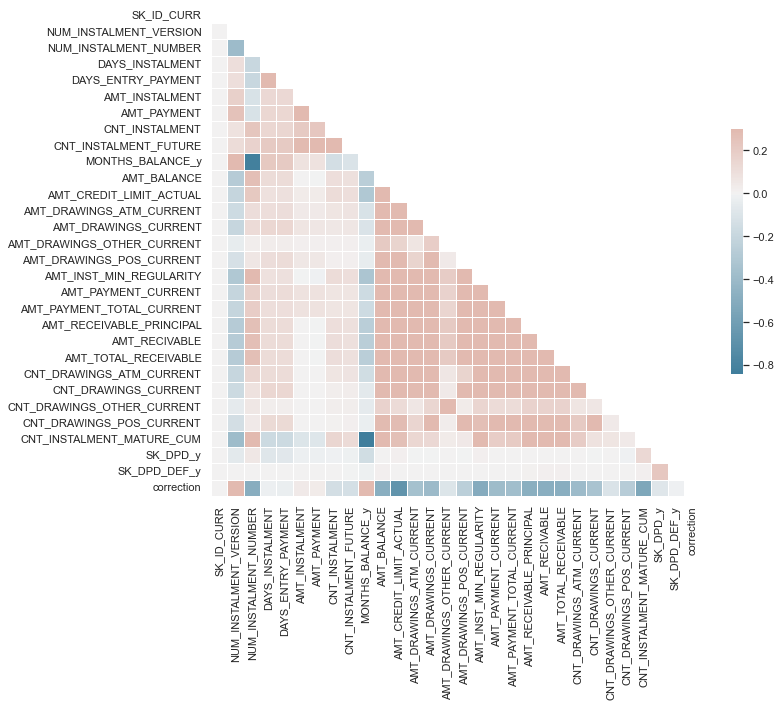

In [93]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

train = train.drop(columns=["MONTHS_BALANCE_y"])
test = test.drop(columns=["MONTHS_BALANCE_y"])

In [94]:
print('Size of train data', train.shape)
print('Size of test data', test.shape)

Size of train data (307511, 29)
Size of test data (48744, 29)


## __Model Training__

We fit logistic regression using all of our training data set. Then, predict the probability for both training and test data sets.

In [95]:
def test_accuracy(train, target, test):
  
    def transform(prob):
        return np.log(prob/(1-prob))

    x = train.iloc[:,1:]
    X_test = test.iloc[:,1:]

    clf = LogisticRegression(class_weight='balanced').fit(x,target)
    prediction = clf.predict(X_test)

    train_prob = clf.predict_proba(x)[:, 1]
    test_prob = clf.predict_proba(X_test)[:, 1]

    train_prob = pd.DataFrame(train_prob, columns=["SCORE_PAY"])
    train_prob = pd.concat([train_ind,train_prob],axis=1)
    test_prob = pd.DataFrame(test_prob, columns=["SCORE_PAY"])
    test_prob = pd.concat([test_ind,test_prob],axis=1)

    return train_prob, test_prob

In [96]:
train_prob, test_prob = test_accuracy(train, target, test)
train_prob.to_csv('combo-data/pay_train_score.csv', index=False)
test_prob.to_csv('combo-data/pay_test_score.csv', index=False)

In [97]:
del train
del test

# __Part IV, Model Combo and Evaluation__

## __Model Combo__
In this section, we combine the predicted scores using a combo model, which is essentially another logistic regression model. We first convert the predicted probability back to log scale with $s = \mathbf{log}(\frac{p}{1 - p})$.

In [98]:
def prob2log(p):
    """Convert probability to score on log scale"""
    
    return np.log(p / (1 - p + 1e-9) + 1e-9)

In [99]:
# Load sub-model prediction
df_combo_train = pd.concat([
    pd.read_csv('combo-data/app_train_score.csv', index_col='SK_ID_CURR'),
    pd.read_csv('combo-data/pay_train_score.csv', index_col='SK_ID_CURR'),
    pd.read_csv('combo-data/bu_train_score.csv', index_col='SK_ID_CURR'),
    pd.read_csv('raw-data/application_train.csv', index_col='SK_ID_CURR', usecols=['SK_ID_CURR', 'TARGET'])
], axis=1)
print(df_combo_train.isna().sum())

# Convert scores back to log scale
col_score = df_combo_train.filter(regex=r'SCORE', axis=1).columns
df_combo_train.loc[:, col_score] = df_combo_train.loc[:, col_score].apply(prob2log, axis=0)

# Add a dummy column for credit bureau score when the score is missing
df_combo_train.loc[:, 'SCORE_BU_MISSING'] = df_combo_train.loc[:, 'SCORE_BU'].isna().astype('float')
df_combo_train.loc[:, 'SCORE_BU'] = df_combo_train.loc[:, 'SCORE_BU'].fillna(0)

SCORE_APP        0
SCORE_PAY        0
SCORE_BU     44020
TARGET           0
dtype: int64


In [100]:
df_combo_train.head()

SCORE_APP  SCORE_PAY  SCORE_BU  TARGET  SCORE_BU_MISSING
SK_ID_CURR                                                          
100002       2.821734  -0.028837 -2.340409       1               0.0
100003      -0.913692  -0.132185 -3.910590       0               0.0
100004      -1.103183  -0.070272 -2.580327       0               0.0
100006      -0.158728  -0.422545  0.000000       0               1.0
100007       0.077194  -0.081475 -2.696422       0               0.0

In [101]:
# Refit the model
model_combo = LogisticRegression(class_weight='balanced').fit(
    df_combo_train.filter(regex=r'SCORE', axis=1), 
    df_combo_train.loc[:, 'TARGET']
)
df_combo_train = df_combo_train.assign(
    PROBA=model_combo.predict_proba(df_combo_train.filter(regex=r'SCORE', axis=1))[:, 1]
)

# Check AUC and Accuracy
print(f'Train combo auc: {roc_auc_score(df_combo_train.TARGET, df_combo_train.PROBA):.3f}')
print(f'Train combo acc: {accuracy_score(df_combo_train.TARGET, df_combo_train.PROBA > 0.5):.3f}')

Train combo auc: 0.748
Train combo acc: 0.686


From the evaluation results shown below, we can see that, though performs well w.r.t. AUC, the precision is pretty bad. But this is understandable as the positive samples are very scarce comparing to negative samples. Thus, even if the false positive rate is not high, the sheer volume is still quite large. Also from the sample distribution along predicted score, we can see that the samples are largely overlapping with each other, though having different sample mean.

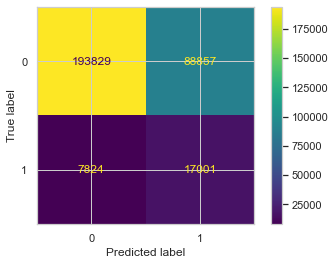

In [102]:
# Confusion Matrix
plt_cfs = ConfusionMatrixDisplay(
    confusion_matrix(df_combo_train.TARGET, df_combo_train.PROBA > 0.5),
    display_labels=model_combo.classes_
)
plt_cfs.plot()

<AxesSubplot:xlabel='Score', ylabel='Count'>

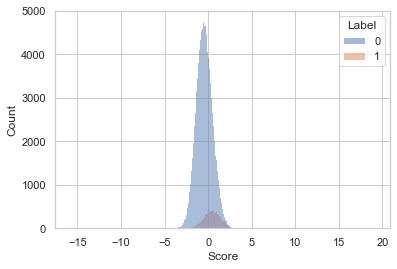

In [103]:
# Distribution alone score
fig_scr, ax_scr = plt.subplots(1, 1)
sns.histplot(
    data={'Label': df_combo_train.TARGET, 'Score': prob2log(df_combo_train.PROBA)},
    x='Score',
    hue='Label'
)

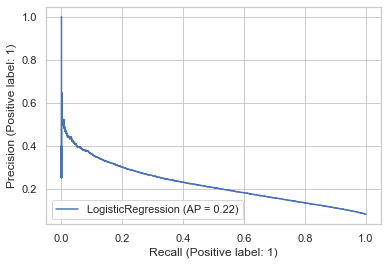

In [104]:
# P-R Curve
PrecisionRecallDisplay.from_estimator(
    model_combo, 
    df_combo_train.filter(regex=r'SCORE', axis=1),
    df_combo_train.TARGET
)
plt.show()

## __Prediction on Test Dataset__

Our model has an AUC of 0.736 on test dataset, evaluated on _Kaggle_. The training AUC is 0.748; so, the over-fitting problem is not server. The SOTA result of the competition is 0.81. Thus, though far from perfect, our model is satisfactory.

In [105]:
# Load test data and predict
df_combo_test = pd.concat([
    pd.read_csv('combo-data/app_test_score.csv', index_col='SK_ID_CURR'),
    pd.read_csv('combo-data/pay_test_score.csv', index_col='SK_ID_CURR'),
    pd.read_csv('combo-data/bu_test_score.csv', index_col='SK_ID_CURR')
], axis=1)
print(df_combo_test.isna().sum())

# Convert scores back to log scale
col_score = df_combo_test.filter(regex=r'SCORE', axis=1).columns
df_combo_test.loc[:, col_score] = df_combo_test.loc[:, col_score].apply(prob2log, axis=0)

# Add a dummy column for credit bureau score when the score is missing
df_combo_test.loc[:, 'SCORE_BU_MISSING'] = df_combo_test.loc[:, 'SCORE_BU'].isna().astype('float')
df_combo_test.loc[:, 'SCORE_BU'] = df_combo_test.loc[:, 'SCORE_BU'].fillna(0)

SCORE_APP       0
SCORE_PAY       0
SCORE_BU     6424
dtype: int64


In [106]:
df_combo_test.head()

SCORE_APP  SCORE_PAY  SCORE_BU  SCORE_BU_MISSING
SK_ID_CURR                                                  
100001      -0.850551  -0.202094 -2.335403               0.0
100005       1.113068  -0.055423 -1.913656               0.0
100013      -1.165518  -0.205046 -3.558857               0.0
100028      -0.607248  -0.563053 -2.344447               0.0
100038       0.626323  -0.058603  0.000000               1.0

In [107]:
# Predict and submit to Kaggle
df_combo_test = df_combo_test.assign(
    TARGET=model_combo.predict_proba(df_combo_test.filter(regex=r'SCORE', axis=1))[:, 1]
)
df_combo_test.loc[:, ['TARGET']].to_csv('submission.csv')

# __Conclusion__

Overall, we have achieved a satisfactory result. But, there is still a huge space for improvement, primarily in three aspects.

First of all, we did not try a variety of models. We only used logistic regression as our model architecture. However, logistic regression has a very strong linear assumption (on log scale). Therefore, if the underlying structure is non-linear, we may miss it. Thus, we can try some non-linear models like random forest or GBDT.

Secondly, there are much more feature engineering we can do. For the applicants data, we can derive some ratio feature such as number of children divided by housing area. Because, if there isn't much people within the family, the living area is inherently small, which does not indicate a bad living environment. For payment data, here we used a simple mean aggregation. However, we can also use sliding windows to capture the fluctuation in the applicants' payment behavior.

Lastly, the error analysis should also be improved. Instead of stopping at confusion matrix, we can profile the mis-classifications to see it there is a consistent pattern within the false positives so that we can add such pattern to our model as well.